In [65]:
using JLD2 
using Plots
using StatsBase
using Random

In [227]:
f = jldopen("../../Data/NASA_KeplerV2/datasets/KeplerLightCurveOrig.jld2", "r");
X_train = read(f, "X_train");
X_test = read(f, "X_test");
y_train = read(f, "y_train")
y_test = read(f, "y_test");

In [228]:
c6_idxs = findall(x -> x .== 6, y_train)

17-element Vector{Int64}:
 904
 905
 906
 907
 908
 909
 910
 911
 912
 913
 914
 915
 916
 917
 918
 919
 920

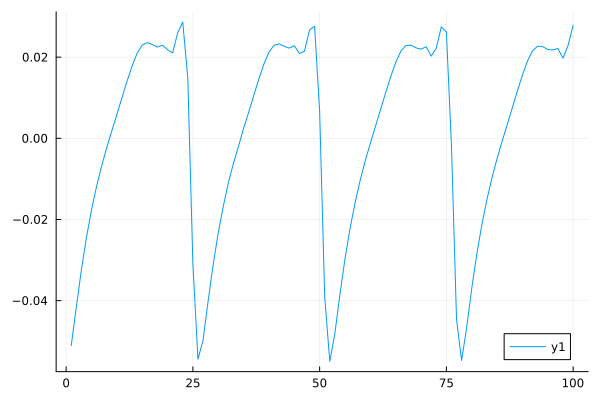

In [233]:
plot(X_train[c6_idxs[2], 1:100])

In [ ]:
plot()

In [225]:
# # isolate class 6 (contact EB)
# contact_eb_tr_idxs = findall(x -> x .== 6, y_train);
# contact_eb_te_idxs = findall(x -> x .== 6, y_test);
# X_train_contact_eb = X_train[contact_eb_tr_idxs, :]
# X_test_contact_eb = X_test[contact_eb_te_idxs, :];
# y_train_contact_eb = zeros(Int, size(X_train_contact_eb, 1));
# y_test_contact_eb = zeros(Int, size(X_test_contact_eb, 1));

In [196]:
function detect_flat_regions(data)
    flat_regions = []
    for i in 2:length(data)
        if data[i] == data[i-1]
            push!(flat_regions, i)
        end
    end
    return flat_regions
end

detect_flat_regions (generic function with 1 method)

In [197]:
function make_overlapping_windows(ts::Vector{Float64}, window_size::Int, stride::Int)
    n = length(ts)
    windows = [ts[i:i+window_size-1] for i in 1:stride:n-window_size+1]
    return windows
end

make_overlapping_windows (generic function with 1 method)

In [251]:
wins = make_overlapping_windows(X_train[c6_idxs[2], :], 100, 95)
corrupted_window_idxs = findall(length.(detect_flat_regions.(wins)) .> 4)
train_idxs, test_idxs = split_train_test(wins, corrupted_window_idxs, 43)
X_train = vcat(wins[train_idxs]'...)
X_test = vcat(wins[test_idxs]'...)
y_train = zeros(Int64, size(X_train, 1));
y_test = zeros(Int64, size(X_test, 1));

In [252]:
jldopen("kep_c6_test.jld2", "w") do f
    f["X_train"] = X_train
    f["X_test"] = X_test
    f["y_train"] = y_train
    f["y_test"] = y_test
end;

In [198]:
function split_train_test(windows::Vector, exclude_indexes::Vector{Int}, train_size::Int)
    test_size = length(windows) - train_size
    test_indexes = exclude_indexes
    remaining_indexes = setdiff(1:length(windows), exclude_indexes)
    # now select the training set from the remaining indices
    train_idxs = shuffle(remaining_indexes)[1:train_size]
    test_idxs = vcat(test_indexes, setdiff(remaining_indexes, train_idxs))
    return train_idxs, test_idxs
end

split_train_test (generic function with 2 methods)

In [199]:
train_idxs, test_idxs = split_train_test(windows, corrupted_window_idxs, 46)

([32, 30, 23, 1, 9, 17, 13, 12, 2, 46  …  45, 14, 5, 10, 3, 33, 26, 48, 38, 18], [20, 21, 36, 43, 31, 51])

In [146]:
# X_train = vcat(windows[train_idxs]'...)
# X_test = vcat(windows[test_idxs]'...);
# y_train = zeros(Int64, size(X_train, 1));
# y_test = zeros(Int64, size(X_test, 1));

In [222]:
num_train_per_samp = 10
X_train_all = []
X_test_all = []
for i in 1:size(X_train_contact_eb, 1)
    samp = X_train_contact_eb[3,:];
    windows = make_overlapping_windows(samp, 100, 1)
    corrupted_window_idxs = findall(length.(detect_flat_regions.(windows)) .> 4)
    train_idxs, test_idxs = split_train_test(windows, corrupted_window_idxs, num_train_per_samp)
    push!(X_train_all, windows[train_idxs]...)
    push!(X_test_all, windows[test_idxs]...)
end 

In [223]:
X_train = vcat(X_train_all'...)
X_test = vcat(X_test_all'...)
y_train = zeros(Int64, size(X_train, 1));
y_test = zeros(Int64, size(X_test, 1));

In [224]:
jldopen("contact_ebTest.jld2", "w") do f
    f["X_train"] = X_train
    f["X_test"] = X_test
    f["y_train"] = y_train
    f["y_test"] = y_test
end;